In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import pickle
import gc
import re
from pytorch_memlab import MemReporter
from torchinfo import summary
# ここから自作
import model
import result
import mode
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# 時刻を表示してくれるようになるprint関数のwrapper
def datePrint(*args, **kwargs):
    from datetime import datetime
    print(datetime.now().strftime('[%Y/%m/%d %H:%M:%S] '), end="")
    print(*args, **kwargs)

In [ ]:
datePrint("loading pickle data")
input_val0 = pickle.load(open("../data/max_span100_512/input_val0.pkl","rb"))
target_val0 = pickle.load(open("../data/max_span100_512/target_val0.pkl","rb")) #512のみ
target_val0 = torch.flip(target_val0, dims=[1])
input_val1 = pickle.load(open("../data/max_span100_512/input_val1.pkl","rb"))
target_val1 = pickle.load(open("../data/max_span100_512/target_val1.pkl","rb")) #512のみ
target_val1 = torch.flip(target_val1, dims=[1])
input_val2 = pickle.load(open("../data/max_span100_512/input_val2.pkl","rb"))
target_val2 = pickle.load(open("../data/max_span100_512/target_val2.pkl","rb")) #512のみ
target_val2 = torch.flip(target_val2, dims=[1])
input_val3 = pickle.load(open("../data/max_span100_512/input_val3.pkl","rb"))
target_val3 = pickle.load(open("../data/max_span100_512/target_val3.pkl","rb")) #512のみ
target_val3 = torch.flip(target_val3, dims=[1])

# input_all = torch.cat([input_val1, input_train2, input_val2, input_train3, input_val3], dim=0)
# target_all = torch.cat([target_val1, target_train2, target_val2, target_train3, target_val3], dim=0)
input_train = torch.cat([input_val0, input_val1, input_val2], dim=0)
target_train = torch.cat([target_val0, target_val1, target_val2], dim=0)
train_dataset = model.Dataset(input_train, target_train)
val_dataset = model.Dataset(input_val3, target_val3)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [1800000, 200000])

del input_val0, target_val0, input_val1, target_val1, input_val2, target_val2, input_val3, target_val3
gc.collect()

In [ ]:
import math
def lambda_epoch(epoch):
    # スケジューラの設定
    max_epoch = 20
    return math.pow((1-epoch/max_epoch), 0.9)

In [ ]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

for n in [0]:
    for x in [0]:
        datePrint(n, 'nani', x, 'layer')
        net = model.dilation1(num_layer=16, num_filters=128, kernel_sizes=5).to(device)
        net.apply(model.weight_init) #重みの初期化適用
        print(summary(net, input_size=([batch_size, 512])))
#         reporter = MemReporter(net)
#         reporter.report()
        #ファインチューニング
#         optimizer = optim.Adam([{'params': net.embedding.parameters(), 'lr': 5e-4},
#                                 {'params': net.convs.parameters(), 'lr': 1e-4},
#                                 {'params': net.mid.parameters(), 'lr': 5e-4},
#                                 {'params': net.fc.parameters(), 'lr': 1e-3}], weight_decay=1e-6)
        optimizer = optim.RMSprop(net.parameters(), lr=1e-4, weight_decay=1e-6, eps=1e-6)
        epochs = 20
        criterion = nn.MSELoss().to(device)
#         # 学習途中データ
#         checkpoint = torch.load('max_span100.pth')
#         net.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epochs = checkpoint['epoch']
#         loss = checkpoint['loss']
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)
        train_loss_list, val_loss_list, data_all, target_all, output_all = mode.train(device, net, dataloaders_dict, criterion, optimizer, epochs)               
        torch.save(net.state_dict(), 'di_scse_fix.pth') #普通のデータのscSE'di_scse.pth'
    
#         print(f'memory report')
#         reporter.report()
        
        result.learning_curve(train_loss_list, val_loss_list, epochs)
        result.plot_result(np.array(target_all, dtype=object).reshape(-1), np.array(output_all, dtype=object).reshape(-1))
        cor_list, loss_list = result.cal_indicators(target_all, output_all)
        result.loss_hist(loss_list)
        result.cor_hist(cor_list)
        loss_sort, cor_sort = result.sort_list(loss_list, cor_list)
        dic = {'best loss': loss_sort[0],  'worst loss': loss_sort[-1], '10th bad loss': loss_sort[-10],'100th bad loss': loss_sort[-100],
                  'best cor': cor_sort[-1], 'worst cor': cor_sort[0], '10th bad cor': cor_sort[9],'100th bad cor': cor_sort[99]} 
        for k, v in dic.items():
            print(k)
            result.visible_one(target_all, output_all, data_all, loss_list, cor_list, idx=v)

In [ ]:
# 作りたてほやほやをinputとtargetに渡すよ
input_array = []
target_array = []
for i in range(10):
    input_path = f"../data/makedata/val/index/input_{i+1}.csv"
    target_path = f"../data/makedata/val/accessibility/target_{i+1}.csv"
    input_array.append(torch.Tensor(np.loadtxt(input_path, delimiter=",", dtype=np.float).astype(np.int)))
    target_array.append(torch.Tensor(np.loadtxt(target_path, delimiter=",", dtype=np.float)))


In [3]:
# input_test = pickle.load(open("../data/test_sets/input_600_1000.pkl","rb"))
# target_test = pickle.load(open("../data/test_sets/target_600_1000.pkl","rb"))
# input_test = pickle.load(open("../data/RF00156/input_RF00156.pkl","rb"))
# target_test = pickle.load(open("../data/RF00156/target_RF00156.pkl","rb"))
# input_test = torch.stack(input_array)
# target_test = torch.stack(target_array)

# target_test = torch.flip(target_test, dims=[1])

input_test = pickle.load(open("../data/max_span100_512/input_val15.pkl","rb"))
target_test = pickle.load(open("../data/max_span100_512/target_val15.pkl","rb")) #512のみ
target_test = torch.flip(target_test, dims=[1])
# input_test = input_test[0:10000] 
# target_test = target_test[0:10000]

datePrint(input_test.shape)
datePrint(target_test.shape)

test_dataset = model.Dataset(input_test, target_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=False, num_workers=1)

net = model.dilation1(num_layer=16, num_filters=128, kernel_sizes=5).to(device)
net.load_state_dict(torch.load('big_data.pth'))
criterion = nn.MSELoss().to(device)

start = time.time()
test_loss, data_all, target_all, output_all = mode.test(device, net, test_dataloader, criterion) 
datePrint('finish prediction loss', test_loss)
    
# np.savetxt('accessibility_output.txt', output_all, fmt='%.3e')
finish = time.time()
datePrint('予測時間', (finish-start))

[2021/08/09 23:33:21] torch.Size([500000, 512])
[2021/08/09 23:33:21] torch.Size([500000, 508])
[2021/08/09 23:39:34] finish prediction loss 1.9647162440795898
[2021/08/09 23:39:34] 予測時間 360.9647047519684


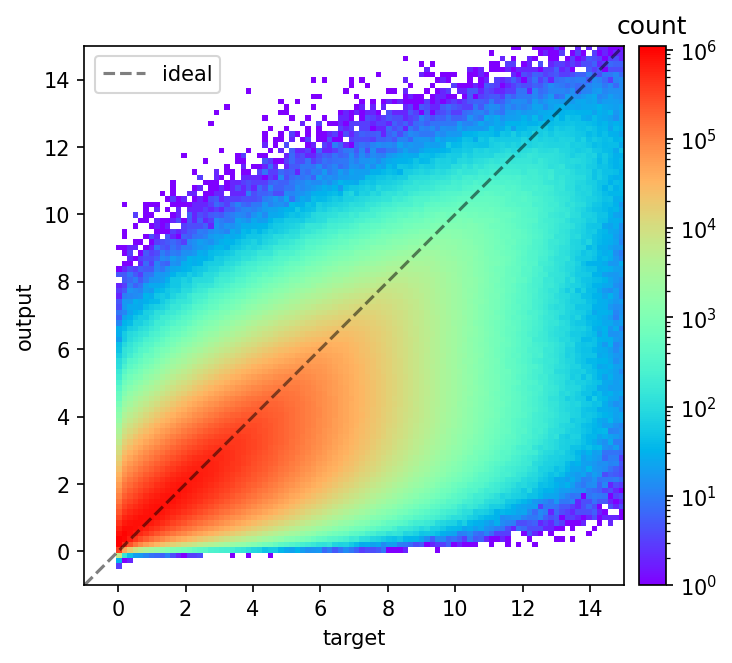

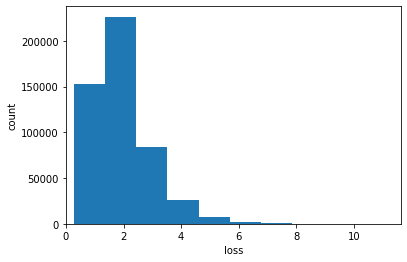

1.9647162


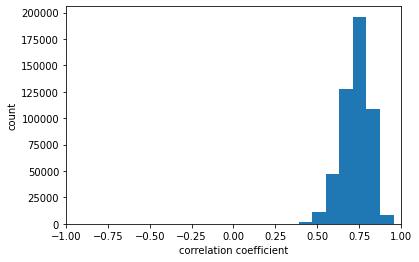

0.7313685179838678
best loss
loss 0.28621486
cor 0.8829314636298101


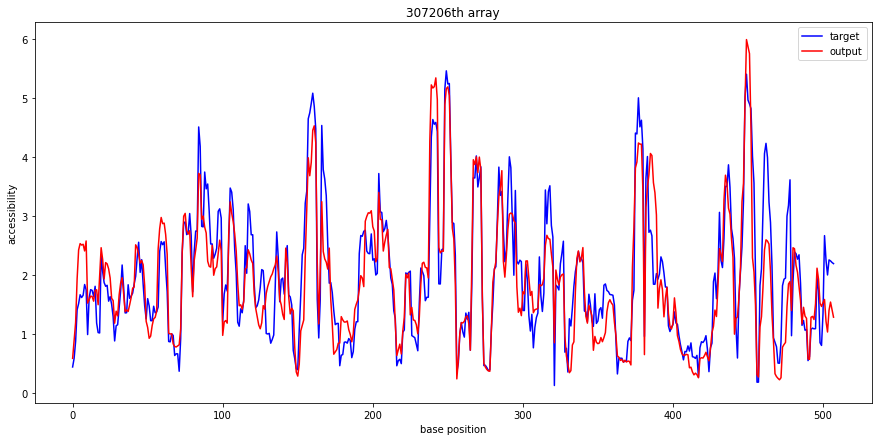

A:0.295, U:0.270, G:0.236, C:0.199
worst loss
loss 8.278076
cor 0.5790941542044526


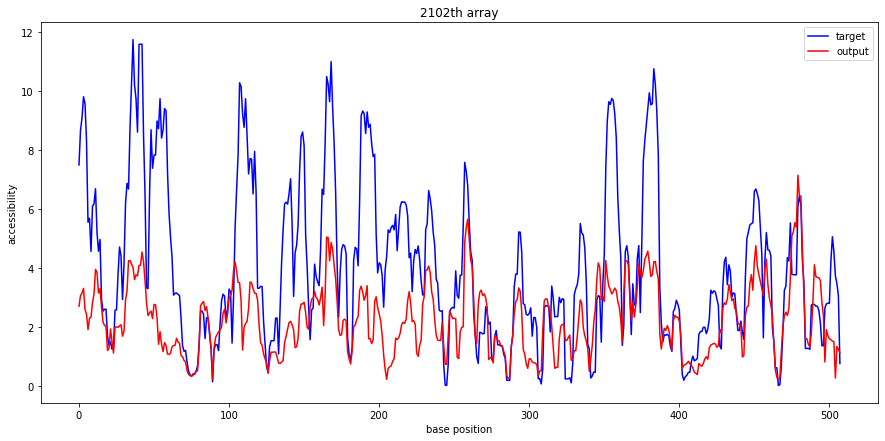

A:0.232, U:0.258, G:0.242, C:0.268
best cor
loss 0.56774086
cor 0.9560696902135345


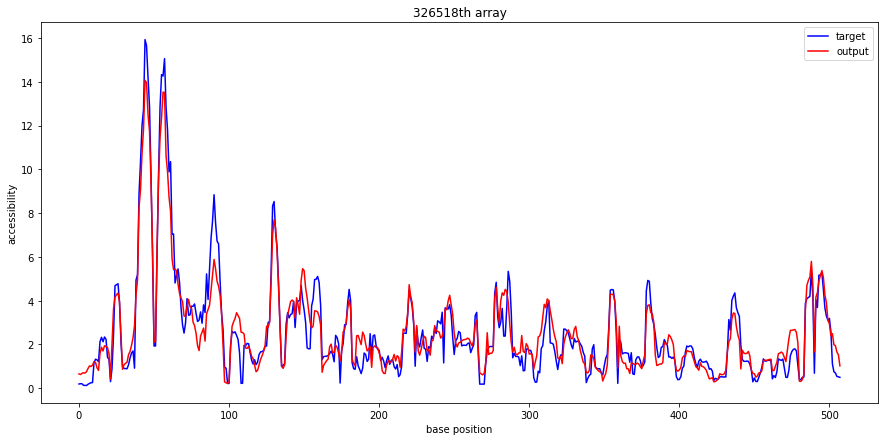

A:0.246, U:0.240, G:0.248, C:0.266
worst cor
loss 3.0471234
cor 0.36631193966061387


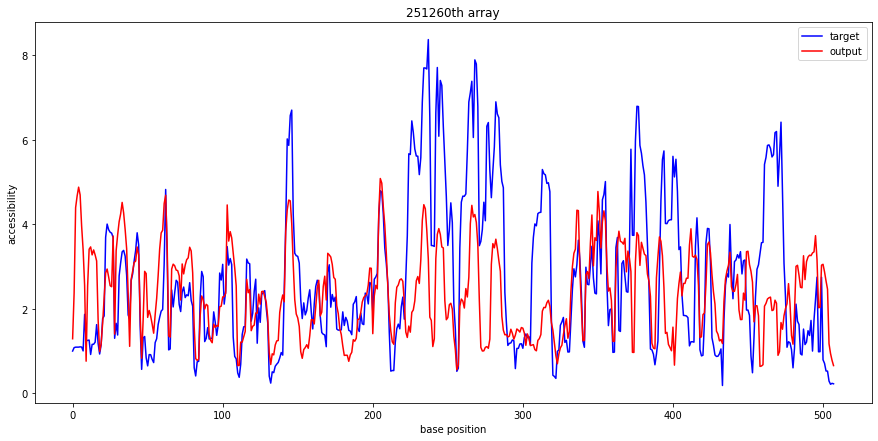

A:0.215, U:0.273, G:0.256, C:0.256


In [4]:
result.plot_result(np.array(target_all, dtype=object).reshape(-1), np.array(output_all, dtype=object).reshape(-1))
cor_list, loss_list = result.cal_indicators(target_all, output_all)
result.loss_hist(loss_list)
result.cor_hist(cor_list)
loss_sort, cor_sort = result.sort_list(loss_list, cor_list)
dic = {'best loss': loss_sort[0],  'worst loss': loss_sort[-100], 'best cor': cor_sort[-1], 'worst cor': cor_sort[100]} 
for k, v in dic.items():
    print(k)
    result.visible_one(target_all, output_all, data_all, loss_list, cor_list, idx=v)

A:0.247, U:0.250, G:0.255, C:0.248
A:0.250, U:0.253, G:0.256, C:0.241


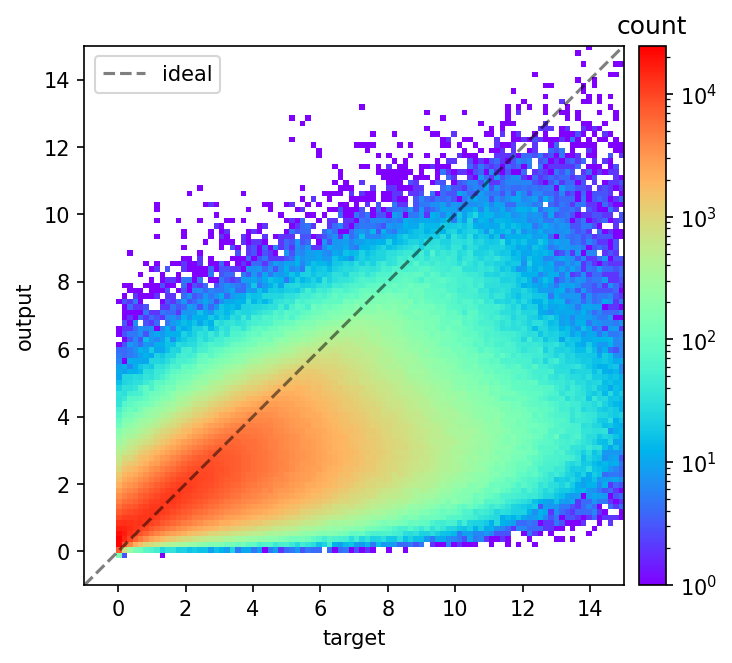

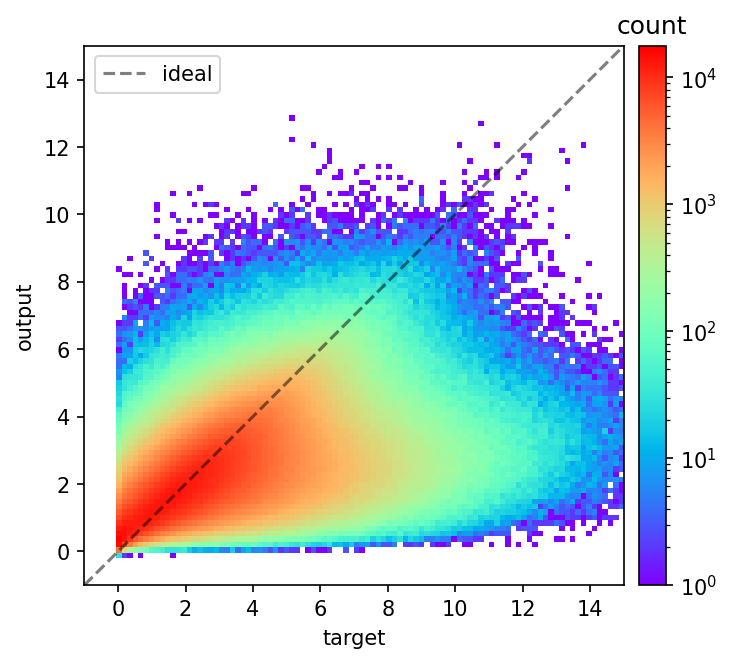

In [11]:
loss_target, loss_output, loss_data, cor_target, cor_output, cor_data = result.remake_bad(target_all, output_all, data_all, loss_sort, cor_sort, length=1000)
result.plot_result(np.array(loss_target, dtype=object).reshape(-1), np.array(loss_output, dtype=object).reshape(-1))
result.plot_result(np.array(cor_target, dtype=object).reshape(-1), np.array(cor_output, dtype=object).reshape(-1))

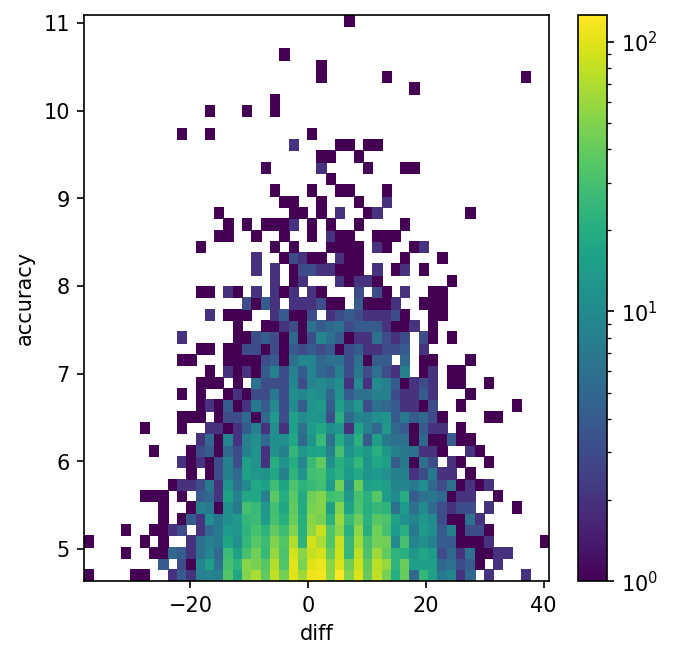

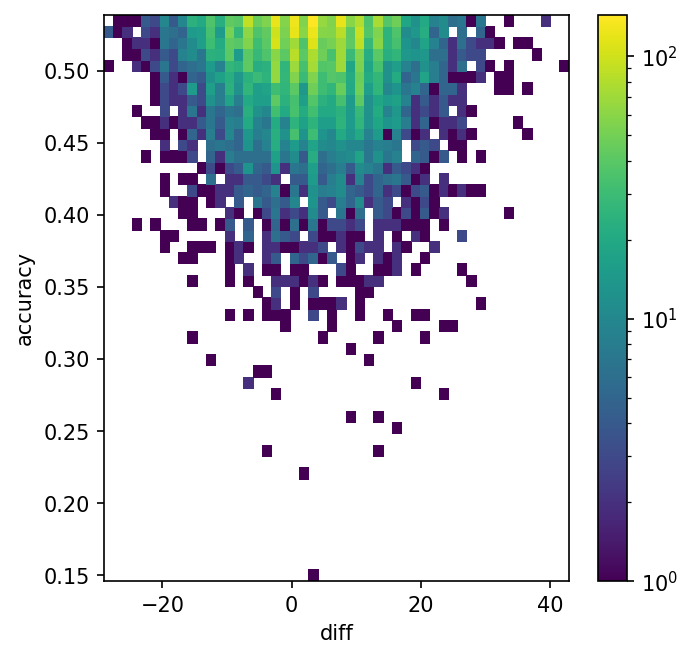

In [22]:
def count_diff(data_all):
    diff_list = []
    for i in data_all:
        count_A, count_U, count_G, count_C = 0, 0, 0, 0
        count_A += np.count_nonzero(i==1)
        count_U += np.count_nonzero(i==2)
        count_G += np.count_nonzero(i==3)
        count_C += np.count_nonzero(i==4)
#         diff = abs(count_A-len(i)/4) + abs(count_U-len(i)/4) + abs(count_G-len(i)/4) + abs(count_C-len(i)/4)
        diff = count_G-len(i)/4
        diff_list.append(diff)

    return diff_list

_, loss_list = result.cal_indicators(loss_target, loss_output)
diff_list = count_diff(loss_data)
result.heat_scatter(diff_list, loss_list)

cor_list, _ = result.cal_indicators(cor_target, cor_output)
diff_list = count_diff(cor_data)
result.heat_scatter(diff_list, cor_list)

# diff_list = count_diff(data_all)
# result.heat_scatter(diff_list, loss_list)
# result.heat_scatter(diff_list, cor_list)

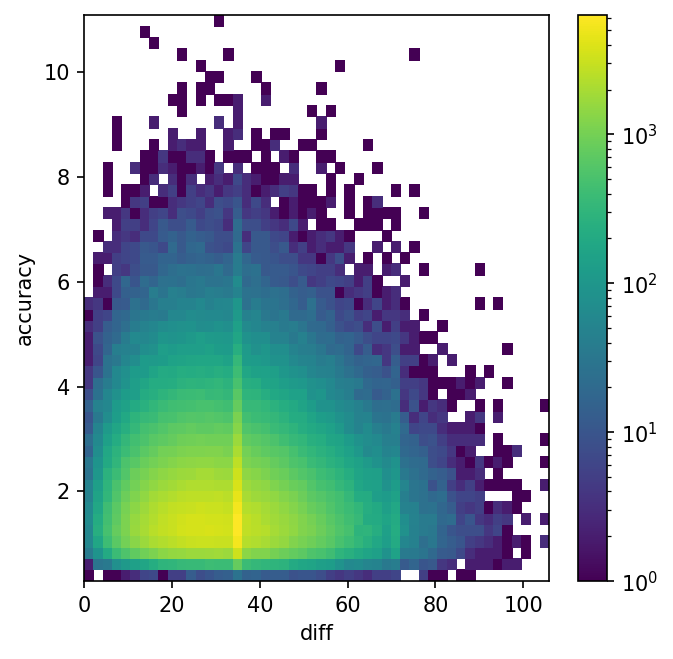

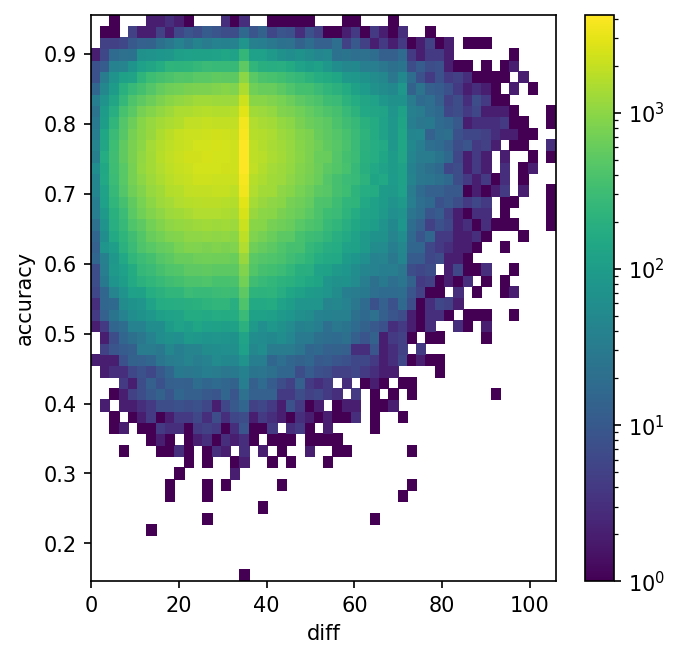

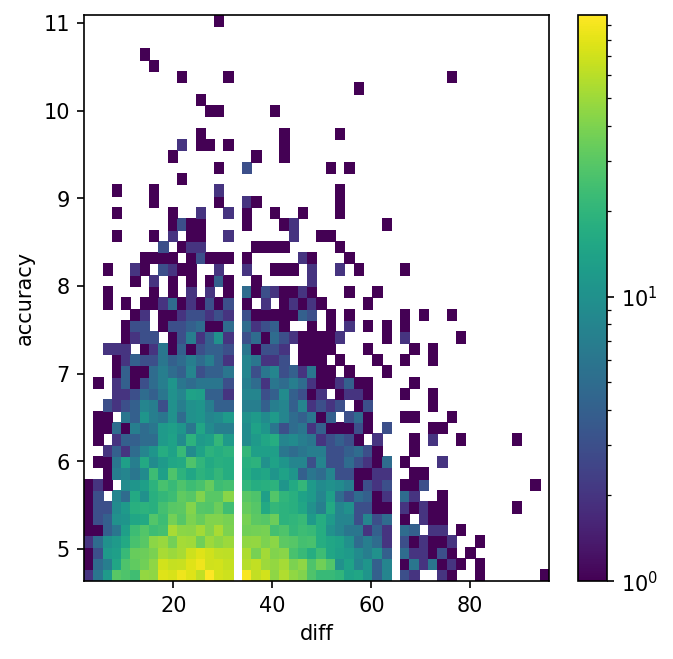

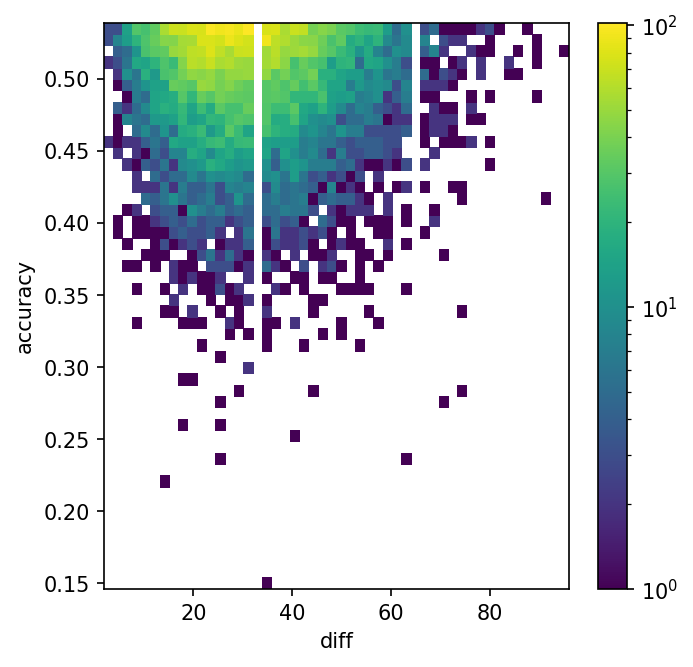

In [27]:
diff_list = result.count_diff(data_all)
result.heat_scatter(diff_list, loss_list)
result.heat_scatter(diff_list, cor_list)

_, loss_bad = result.cal_indicators(loss_target, loss_output)
diff_list = result.count_diff(loss_data)
result.heat_scatter(diff_list, loss_bad)

cor_bad, _ = result.cal_indicators(cor_target, cor_output)
diff_list = result.count_diff(cor_data)
result.heat_scatter(diff_list, cor_bad)

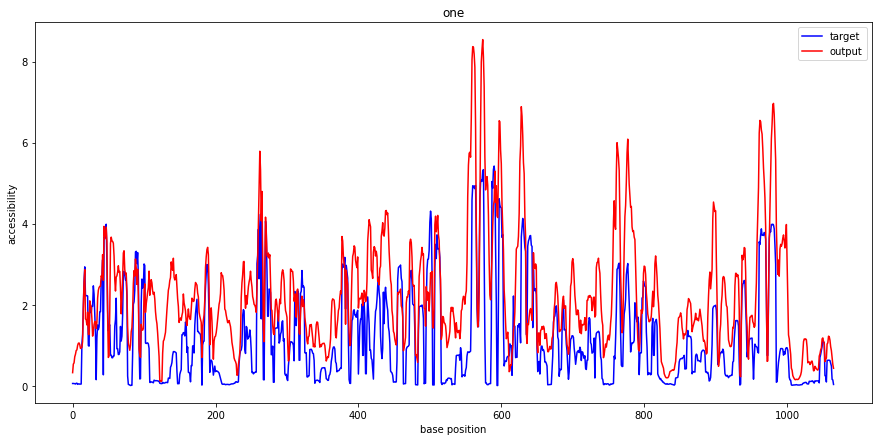

cor 0.7024939114513875
mse 2.1743497246319055
[2021/08/11 11:05:06] 予測時間 0.5327224731445312


In [47]:
start = time.time()
path = "../data/mouse_data/seq1.fa"
with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]
name = seq_file[0]
seq = ''.join(seq_file[1:]).replace('A', '1').replace('T', '2').replace('U', '2').replace('G', '3').replace('C', '4')
input_seq = torch.Tensor(list(map(int, seq)))
input_seq = torch.flip(input_seq, dims=[0])
input_seq = input_seq.unsqueeze(0)
out_length = len(input_seq[0])-4

input_seq = input_seq.unsqueeze(0)

net = model.dilation1(num_layer=16, num_filters=128, kernel_sizes=5).to(device)
net.load_state_dict(torch.load('big_data.pth'))
    
data_all, output_all = mode.predict(device, net, input_seq) 

  
import matplotlib.pyplot as plt
max_length = output_all.shape[1]
with open('../data/mouse_data/out1.txt', 'r') as f:
        next(f)
        acc = f.readlines()
        acc_list = []
        for i in range(len(acc)-1):
                acc_list.append(re.findall(',(.*);', acc[i])[0])
acc_list = [float(x) for x in acc_list]

plt.figure(figsize=(15, 7))
plt.plot(range(out_length), acc_list, label='target', color='b')
plt.plot(range(out_length), output_all[0][:out_length], label='output', color='r')
plt.legend()
plt.xlabel('base position')
plt.ylabel('accessibility')
plt.title('one')
plt.show()


cor = np.corrcoef(acc_list, output_all[0][:out_length])
mse = ((acc_list - output_all[0][:out_length])**2).mean(axis=0)
print('cor', cor[0,1])
print('mse', mse)

    
np.savetxt('accessibility_output.txt', output_all, fmt='%.3f')
finish = time.time()
datePrint('予測時間', (finish-start))

In [ ]:
path = "../data/real_data/RF00156.fa"

start = time.time()
with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]
name_list = []
seq_list = torch.empty(0, 256)

for i in range(len(indexes)-1):
    name_list.append(seq_file[indexes[i]])
    seq = ''.join(seq_file[indexes[i]+1:indexes[i+1]]).replace('A', '1').replace('T', '2').replace('U', '2').replace('G', '3').replace('C', '4').replace('N', '0')
    seq = torch.Tensor(list(map(int, seq)))
    seq = torch.flip(seq, dims=[0])
    if (seq.shape[0]%256 != 0):
        seq = F.pad(seq, (0, 256-seq.shape[0]%256))
    seq = seq.unsqueeze(0)
    seq_list = torch.cat([seq_list, seq], dim=0)


# if (input_seq.shape[1]%256 != 0):
#     input_seq = F.pad(input_seq, (0, 256-input_seq.shape[1]%256))
# if (input_seq.shape[1]>256):
#     transform = True
#     division = (input_seq.shape[1])//128 - 1
#     input_init = input_seq
#     input_seq = input_seq.unfold(1, 256, 128).reshape(-1, 256)
# else:
#     transform = False
# datePrint(input_seq.shape)
# input_seq = input_seq.unsqueeze(0)
# datePrint(input_seq.shape)

seq_list = seq_list.unsqueeze(0)
net = model.Variable(num_layer=16, kernel_sizes=33, flag=False).to(device)
net.load_state_dict(torch.load('max_span20.pth'))
    
data_all, output_all = mode.predict(device, net, seq_list) 
# if (transform==True):
#     output_tmp = torch.tensor(output_all)
#     for n in range(division):
#         if (n==0):
#             output_all = output_tmp[n::division, :192]
#         elif (n==division-1):
#             output_all = torch.cat([output_all, output_tmp[n::division, 64:]], dim=1)
#         else:
#             output_all = torch.cat([output_all, output_tmp[n::division, 64:192]], dim=1)
    
#     data_all = input_init.numpy()
#     output_all = output_all.numpy()
    
np.savetxt('accessibility_output.txt', output_all, fmt='%.3f')
finish = time.time()
datePrint('予測時間', (finish-start))

In [ ]:
# sample作成
path = "../data/RF01210/RF01210.fa"

with open(path, mode = 'r', encoding = 'utf-8') as f:
    seq_file = f.read().splitlines()
indexes = [i for i, n in enumerate(seq_file) if n.startswith('>')]

for i in range(len(indexes)-1):
    with open(f"../data/RF01210/sample_{i}.txt", mode="w") as f:
        f.write(seq_file[indexes[i]] + "\n")
        f.write(''.join(seq_file[indexes[i]+1:indexes[i+1]]))

In [ ]:
# castしちゃう
from pathlib import Path
import numpy as np
from tqdm import tqdm
import pickle
import torch
import sys

for cond, cnt in (("train", 500000), ("test", 500000)):
    data_path = Path(f"../data/makedata/{cond}")
    input_array = []
    target_array = []
    print(f"reading {cond} files")
    for i in tqdm(range(cnt)):
        input_path = data_path / f"index/input_{i+1}.csv"
        target_path = data_path / f"accessibility/target_{i+1}.csv"

        input_array.append(torch.Tensor(np.loadtxt(input_path, delimiter=",", dtype=np.float).astype(np.int)))
        target_array.append(torch.Tensor(np.loadtxt(target_path, delimiter=",", dtype=np.float)))
    print(f"saving to input_{cond}.pkl")
    pickle.dump(torch.stack(input_array), open(f"../data/input_{cond}.pkl", 'wb'))
        
    print(f"saving to target_{cond}.pkl")
    pickle.dump(torch.stack(target_array), open(f"../data/target_{cond}.pkl", 'wb'))


In [ ]:
#メモリ確認
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #10M以上のみ表示
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))